## Phase contrast imaging using multislice ptychography

In this tutorial notebook, we will reconstruct the electrostatic potential of a simulated "thick" Si [110] sample using multislice ptychography.

### Downloads
* [18nm thick Si [110] 4D-STEM dataset](https://drive.google.com/file/d/19NiTlzHFN8CJFbgUKFahLIytwwqijQgp/view?usp=drive_link)
* [[Optional] 28nm thick Si [110] 4D-STEM dataset](https://drive.google.com/file/d/1-jE77b86TH-3ISr5615prRLQA-bBHWvY/view?usp=drive_link)
* [[Optional] 37nm thick Si [110] 4D-STEM dataset](https://drive.google.com/file/d/1z9MJUN4NakdkAJpKMgb5qlR9jLOmKP3s/view?usp=drive_link)

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

The 4D-STEM dataset used here was simulated in abTEM using the following parameters:
- Convergence angle: 20 mrad
- Accelerating voltage: 200 kV
- Probe aberrations: 100 A defocus
- Poisson noise: 10,000 $e/A^2$

_Note:_ You'll notice we use a lot more iterations here as compared to other tutorials. This is in order to capture the very slow-convergenging quantitative phase plateau to illustrate multislice linearity for different thicknesses. As such, we use `device='gpu'` below to ensure reasonable speeds. Note you don't need these many iterations to get a qualitatively correct reconstruction.

Updated 2023 Oct 31

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import py4DSTEM
print(py4DSTEM.__version__)

0.14.8


# Load data, basic visualization

We'll use three different simulated datasets for STO [110] with increasing thicknesses. First, we load the one for a 13nm thick sample and plot the mean diffraction pattern:

In [2]:
file_path = 'data/'

In [3]:
dataset_18nm = py4DSTEM.read(file_path+"ptycho_Si-110_18nm.h5")
dataset_18nm.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1.628833659104038
             R_pixel_size:    0.49668114330171353
             Q_pixel_units:   mrad
             R_pixel_units:   A
)

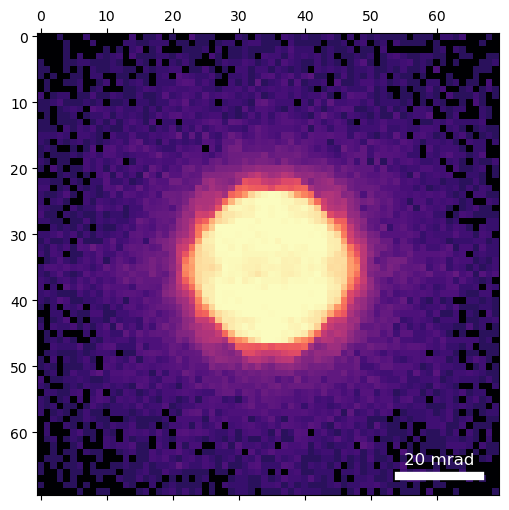

In [4]:
dataset_18nm.get_dp_mean()
py4DSTEM.show(
    dataset_18nm.tree("dp_mean"),
    cmap='magma',
    power=0.25,
    figsize=(6,6),
)

As we can see, the data is fairly noisy - with strong scattering inside the BF disk.

## Single-slice reconstruction

First, let's see how well single-slice reconstruction fares on this dataset:

Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.


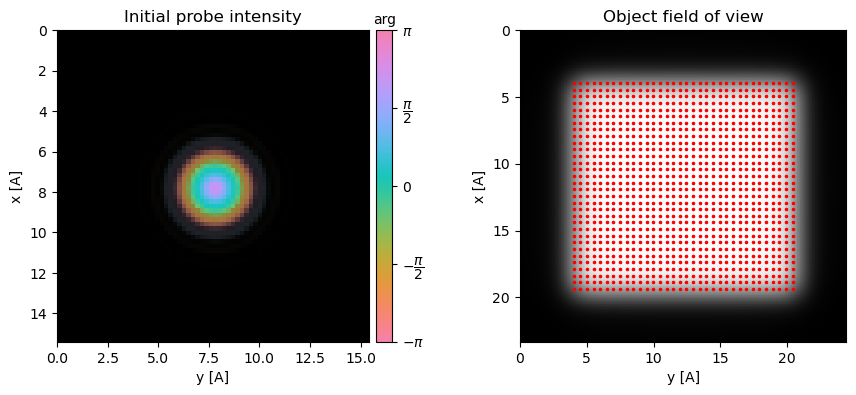

In [5]:
ptycho_18nm = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
    datacube=dataset_18nm,
    verbose=True,
    energy=200e3,
    semiangle_cutoff=20,
    defocus=100,
    device='gpu',
    object_type='potential',
    object_padding_px=(18,18),
).preprocess(
    plot_center_of_mass = False,
    plot_rotation=False,
)

Performing 256 iterations using a potential object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|███████████████████████████████████████████████████████████████████| 256/256 [00:03<00:00, 67.06 iter/s]


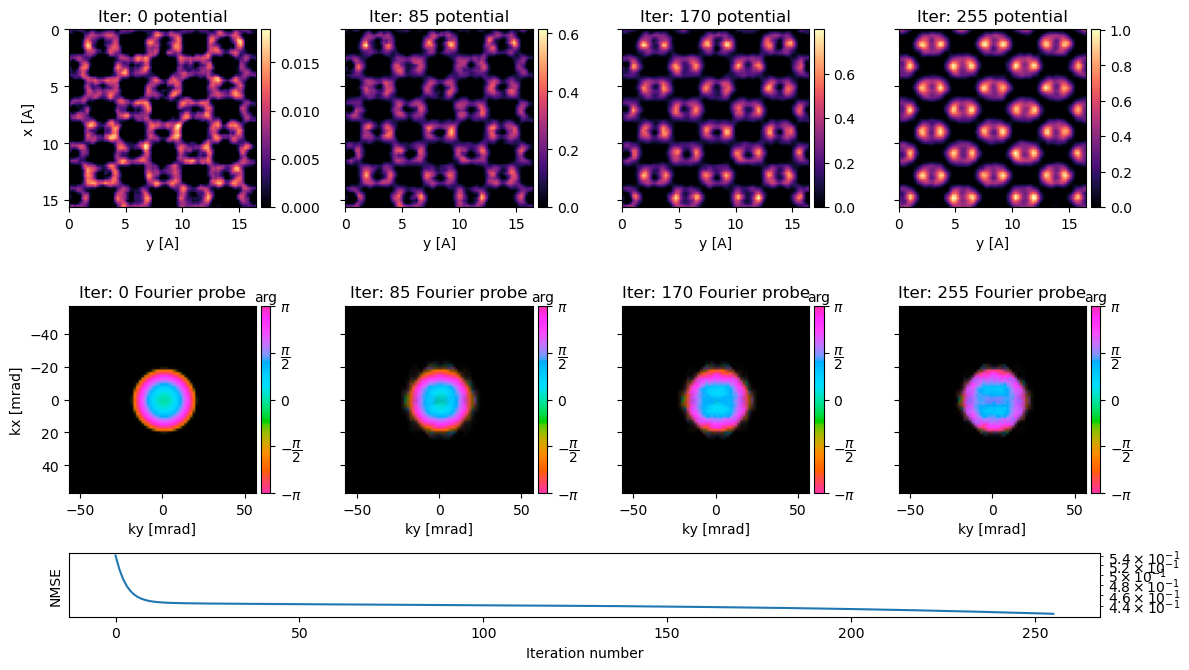

In [6]:
ptycho_18nm = ptycho_18nm.reconstruct(
    reset=True,
    store_iterations=True,
    max_iter = 256,
    step_size = 0.175,
).visualize(
    iterations_grid = 'auto',
    plot_fourier_probe=True,
)

The final reconstructed object is not great, illustrating the breakdown of single-slice ptychography for strongly-scattering objects.

Additionally, the probe is starting to change from a defocused to a focused-geometry. What the algorithm appears to be picking up on is that it can reproduce the measured intensities better if it emulates "channeling".

## Multi-slice ptychography

Let's see if multi-slice ptychography can perform better.
We'll use slices of equal thickness equal to 8 layers of Si [110], or ~3nm.

In [7]:
slice_thicknesses = 30.794230884706234

For our 18nm thick dataset we therefore need 6 slices:

In [8]:
slice_thicknesses*6

184.7653853082374

Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.


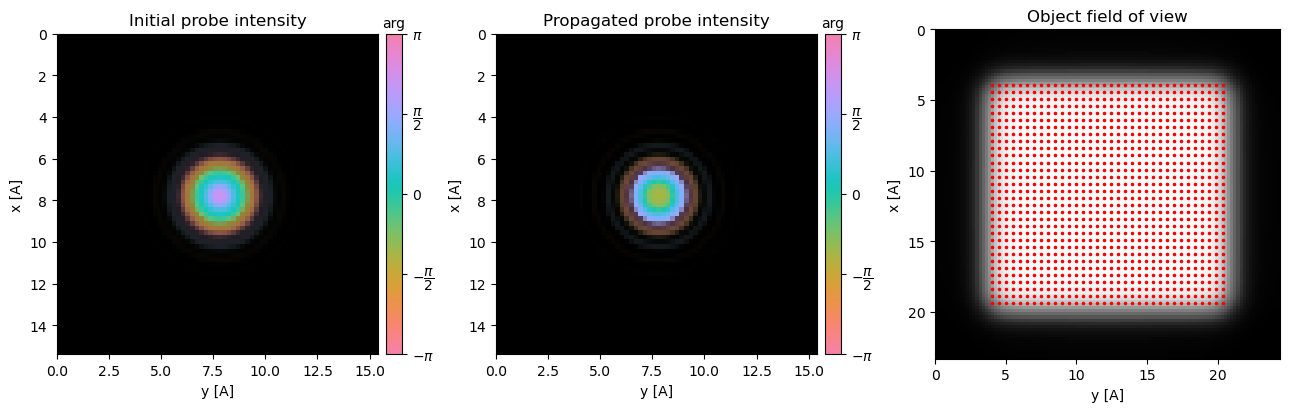

In [10]:
ms_ptycho_18nm = py4DSTEM.process.phase.MultislicePtychographicReconstruction(
    datacube=dataset_18nm,
    num_slices=6,
    slice_thicknesses=slice_thicknesses,
    verbose=True,
    energy=200e3,
    defocus=100,
    semiangle_cutoff=20,
    object_padding_px=(18,18),
    device='gpu',
).preprocess(
    plot_center_of_mass = False,
    plot_rotation=False,
)

Performing 256 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|███████████████████████████████████████████████████████████████████| 256/256 [00:22<00:00, 11.21 iter/s]


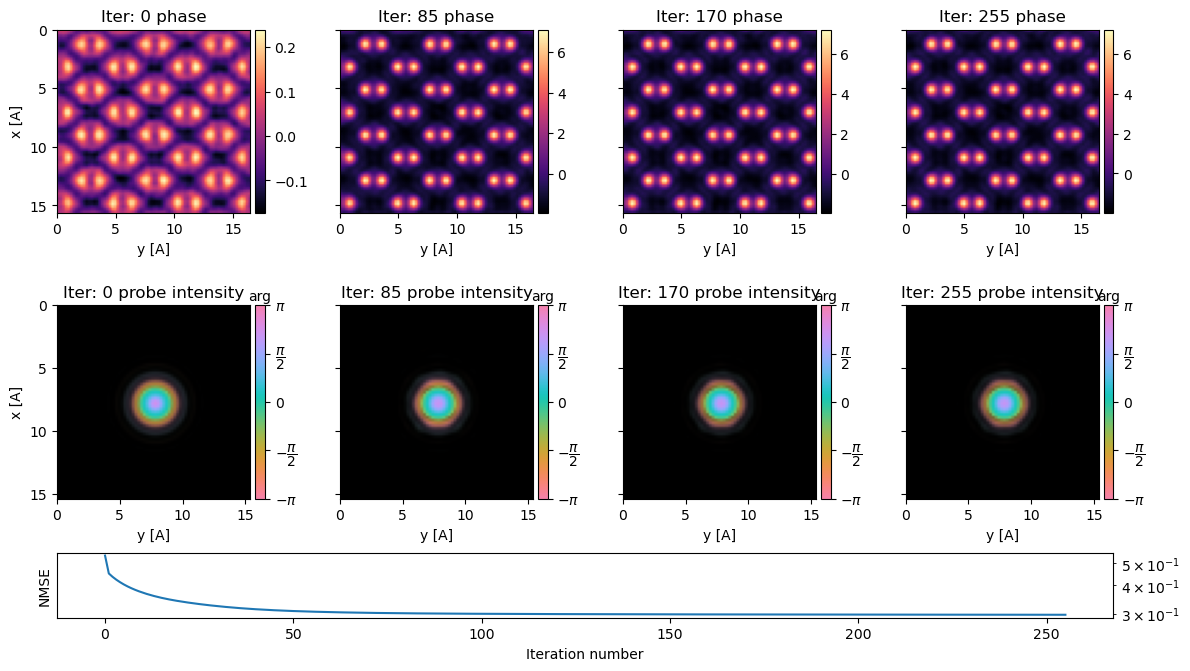

In [15]:
ms_ptycho_18nm = ms_ptycho_18nm.reconstruct(
    reset=True,
    store_iterations=True,
    max_iter = 256,
    identical_slices_iter= 256,
    step_size=0.175,
).visualize(
    iterations_grid = 'auto',
)

Indeed, not only is the object much better reconstructed but the probe looks a lot more physical with the same order of defocus.

Let's compare the complex probes in real and Fourier space:

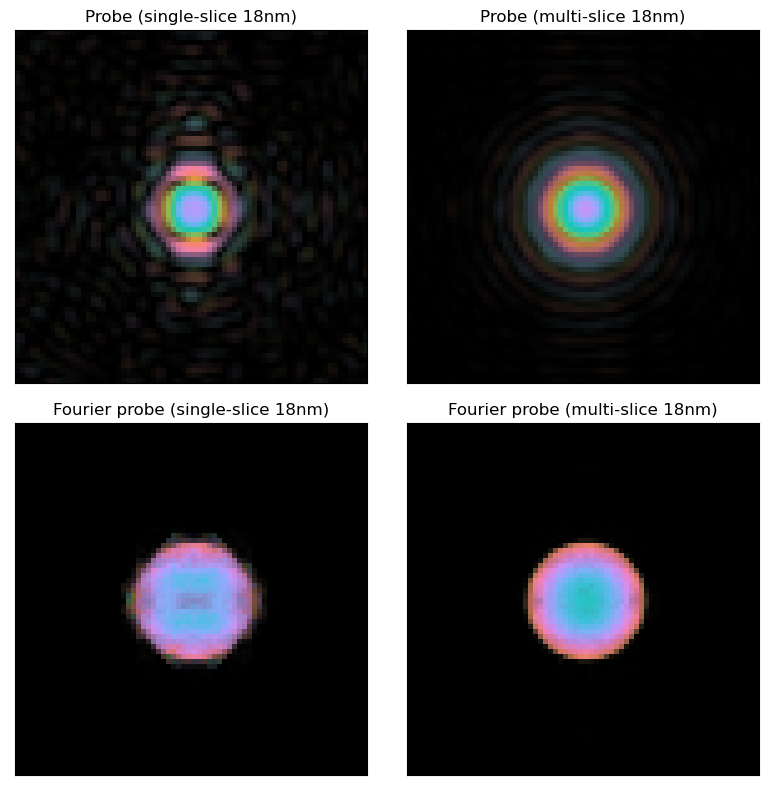

In [16]:
py4DSTEM.show_complex(
    [
        [
            ptycho_18nm.probe_centered,
            ms_ptycho_18nm.probe_centered,
        ],
        [
            ptycho_18nm.probe_fourier,
            ms_ptycho_18nm.probe_fourier,
        ],
    ],
    title=[
        "Probe (single-slice 18nm)","Probe (multi-slice 18nm)",
        "Fourier probe (single-slice 18nm)","Fourier probe (multi-slice 18nm)"
    ],
    axsize=(4,4),
    cbar=False,
    ticks=False,
)

### [Optional] Linearity of multislice-ptychography?

It's also of interest to see how far we can push this, by investigating thicker samples with more slices. Ideally, the phase should be linear and thus our algorith should reconstruct equally well for thicker samples.  
_Note:_ The following cells will take ~3 mins each using `device='cpu'`.

/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:644: UserWarning: Best fit rotation forced to 0 degrees.
  warnings.warn(
/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:658: UserWarning: Transpose of intensities forced to False.
  warnings.warn(


Performing 256 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|███████████████████████████████████████████████████████████████████| 256/256 [00:33<00:00,  7.56 iter/s]


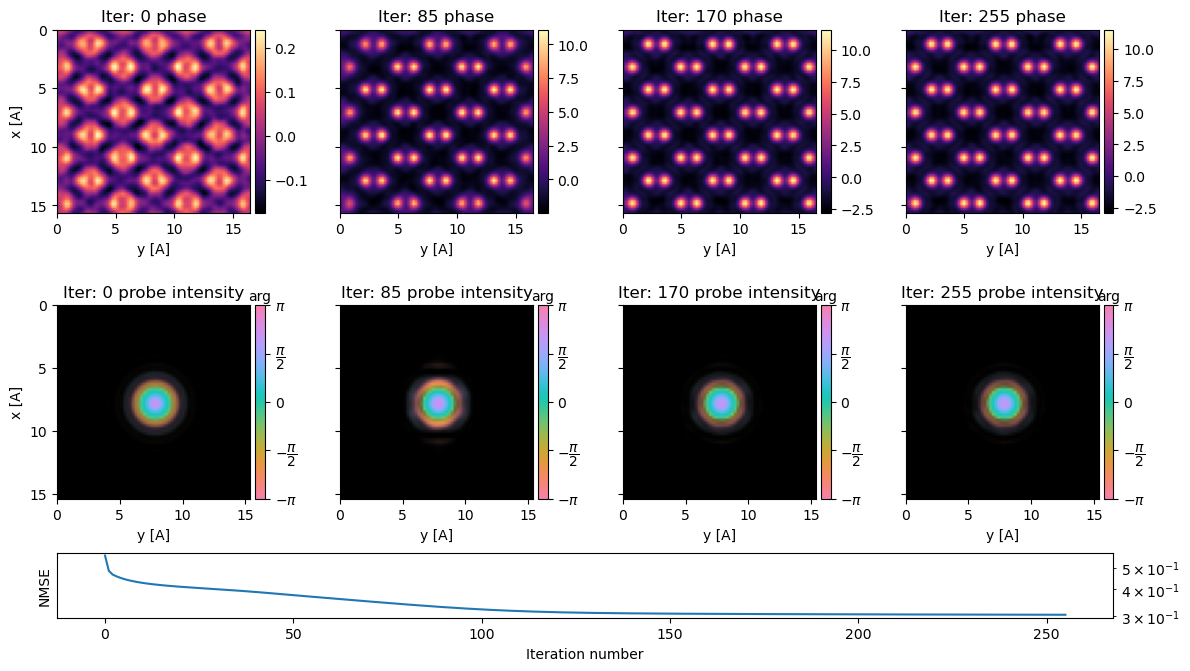

In [17]:
dataset_28nm = py4DSTEM.read(file_path+"ptycho_Si-110_28nm.h5")
ms_ptycho_28nm = py4DSTEM.process.phase.MultislicePtychographicReconstruction(
    datacube=dataset_28nm,
    num_slices=9,
    slice_thicknesses=slice_thicknesses,
    verbose=True,
    energy=200e3,
    defocus=100,
    semiangle_cutoff=20,
    object_padding_px=(18,18),
    #device='gpu',
).preprocess(
    force_com_rotation=0,
    force_com_transpose=False,
    plot_center_of_mass = False,
    plot_probe_overlaps=False,
).reconstruct(
    reset=True,
    store_iterations=True,
    max_iter = 256,
    identical_slices_iter= 256,
    step_size=0.175,
).visualize(
    iterations_grid = 'auto'
)

/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:644: UserWarning: Best fit rotation forced to 0 degrees.
  warnings.warn(
/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:658: UserWarning: Transpose of intensities forced to False.
  warnings.warn(


Performing 256 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|███████████████████████████████████████████████████████████████████| 256/256 [00:44<00:00,  5.71 iter/s]


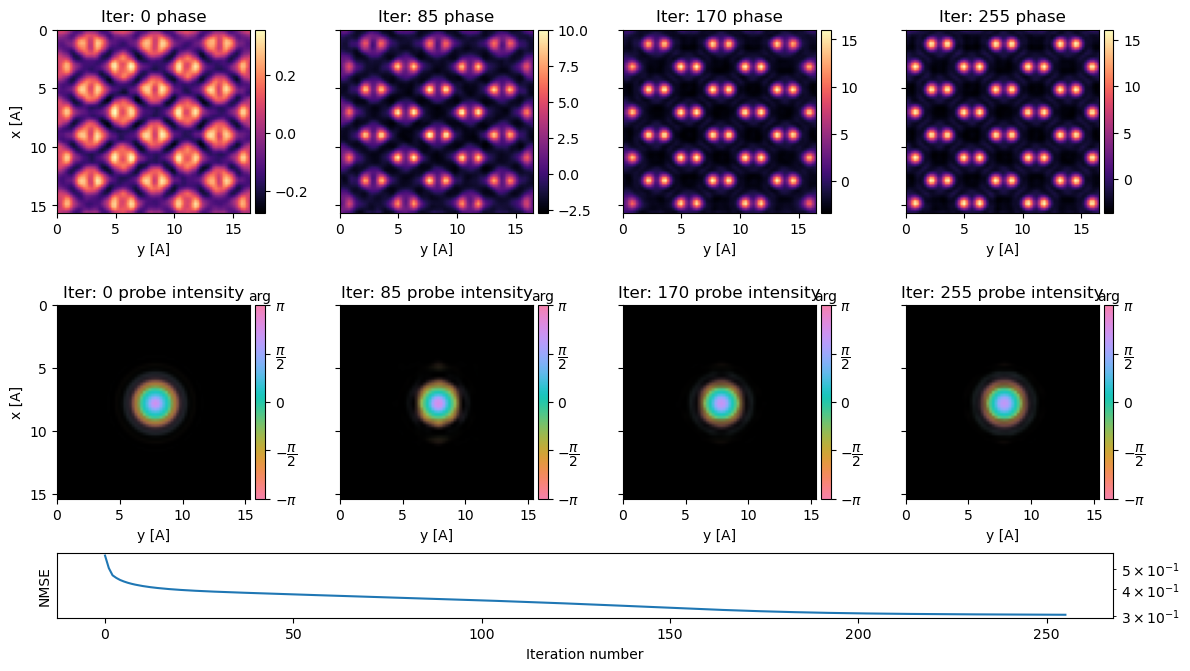

In [18]:
dataset_37nm = py4DSTEM.read(file_path+"ptycho_Si-110_37nm.h5")
ms_ptycho_37nm = py4DSTEM.process.phase.MultislicePtychographicReconstruction(
    datacube=dataset_37nm,
    num_slices=12,
    slice_thicknesses=slice_thicknesses,
    verbose=True,
    energy=200e3,
    defocus=100,
    semiangle_cutoff=20,
    object_padding_px=(18,18),
    #device='gpu',
).preprocess(
    force_com_rotation=0,
    force_com_transpose=False,
    plot_center_of_mass = False,
    plot_probe_overlaps=False,
).reconstruct(
    reset=True,
    store_iterations=True,
    max_iter = 256,
    identical_slices_iter=256,
    step_size=0.175,
).visualize(
    iterations_grid = 'auto'
)

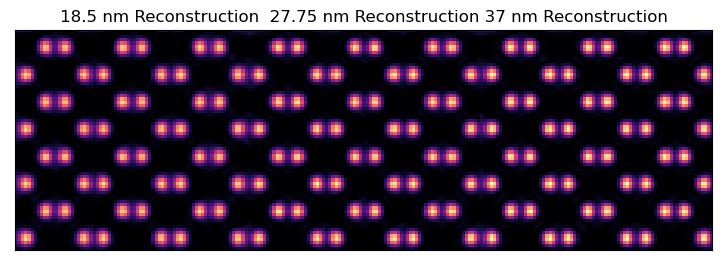

In [19]:
py4DSTEM.show(
    np.hstack((
        np.angle(ms_ptycho_18nm.object_cropped).mean(0),
        np.angle(ms_ptycho_28nm.object_cropped).mean(0),
        np.angle(ms_ptycho_37nm.object_cropped).mean(0),
    )),
    cmap='magma',
    vmin=0.333,
    vmax=0.999,
    ticks=False,
    figsize=(9,3),
    title="18.5 nm Reconstruction\t27.75 nm Reconstruction\t37 nm Reconstruction".expandtabs()
)

Indeed, as we can see the reconstructions are mostly linear for the experimental conditions we have used here.